# Load modules

In [1]:
%matplotlib inline
import getpass
import math
import importlib
import numpy as np
import os
import pyfits
from scipy import integrate, interpolate
import socket
from struct import unpack
import sys
import yt

#astropy
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from astropy.constants import c

#require CosmoloPy
#import cosmolopy.distance as cd

if getpass.getuser()=='ssaito':
    HOMEDIR = '/Users/ssaito/'
elif getpass.getuser()=='shsaito':
    HOMEDIR = '/Users/shsaito/'
    
##CONSTANTS
SQDEGtoSTR = math.pi**2./32400
Mpctocm = 3.0857E+24

## Plot
import matplotlib.pyplot as plt
from matplotlib import ticker, patches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse
# my personal setting
from ss_default_plot import *

# Test logN grid data 

In [4]:
### Read the test data
DIRDATA = HOMEDIR+'Dropbox/Work/Project/LAE/code/lognormal_galaxies/result/hetdex1_rev_KEK/'

datagrid_LAE = np.fromfile(DIRDATA+'LAE_grid_Gdensity_lognormal_is100_rlz0_Pnmax512_b1.5.bin')
datagrid_LAI = np.fromfile(DIRDATA+'LAI_grid_Gdensity_lognormal_is100_rlz0_Pnmax512_b1.5.bin')

#print(datagrid_LAI.shape[0])

## grid setting
Lx = 2880
Ly = 483.75
Lz = 635.625
Lmax = 2880
Nmesh = 512

n0 = int(np.ceil(Nmesh * Lx / Lmax))
n1 = int(np.ceil(Nmesh * Ly / Lmax))
n2 = int(np.ceil(Nmesh * Lz / Lmax))
cn2 = int(n2/2.)+1
cn22 = cn2*2

arr_LAE_grid = np.zeros(shape=(n0,n1,n2))
arr_LAI_grid = np.zeros(shape=(n0,n1,n2))
for i0 in range(n0):
    for i1 in range(n1):
        for i2 in range(n2):
            indx = i2 + cn22*(i1 + n1*i0)
            arr_LAE_grid[i0,i1,i2] = datagrid_LAE[indx]
            arr_LAI_grid[i0,i1,i2] = datagrid_LAI[indx]

Load the **`intensitymap`** module and define the **`Intensity_map`** object as **`imap`**.

In [5]:
PATH_COSMOGRID = HOMEDIR+'Dropbox/Work/Project/LAE/code/intmapy/'
sys.path.append(PATH_COSMOGRID)
from intensitymap import Intensity_map

cp = FlatLambdaCDM(H0=70., Om0=0.272)
imap = Intensity_map(Lbox=[2880.,483.75,635.625], Ngrid=512, z_red=2.1, cp=cp)

Prepare a grid which now contains (RA,DEC,z) coordinates

In [6]:
imap.find_rotation_to_pivot(ra_piv = 195*u.degree, dec_piv = 53*u.degree, z_piv=1.88)
imap.prepare_skycoord_grid()

In [7]:
print(imap.skyc_grid[0,0,0])

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, Mpcph)
    ( 163.51840807,  44.59493672,  3872.32180695)>


Our lognormal code gives the luminosity density, $\rho_{L}({\bf x})$ [erg/s/(Mpc/h)^3]. 
The luminosity density is related to the intensity $I_{\lambda}\,[{\rm erg/s/cm^{2}/Sr/\unicode[.8,0]{x212B}}]$ as
\begin{eqnarray}
  I_{\lambda}(\vec{\theta},\lambda_{0}) = \int dL \frac{dn}{dL}\frac{L({\bf x})}{4\pi D^{2}_{L}}\frac{dV}{d\theta^{2}d\lambda_{0}}, 
\end{eqnarray}
where the volume element $dV/d\theta^{2}d\lambda_{0}\,[{\rm (Mpc/h)^3/Sr/\unicode[.8,0]{x212B}}]$ in each grid cell is given by 
\begin{eqnarray}
 \frac{dV}{d\theta^{2}d\lambda_{0}} = \frac{dXdYdZ}{(dXdY/\chi^{2})(\lambda_{0}H(z)/c/(1+z))dZ} = \frac{c(1+z)}{\lambda_{0}H(z)}\chi^{2}.
\end{eqnarray}
Therefore, intensity (surface brightness?) is obtained as
\begin{eqnarray}
  \lambda_{0}I_{\lambda}(\vec{\theta},\lambda_{0}) = \rho_{L}({\bf x})\times \frac{c}{4\pi(1+z)H(z)}\,[{\rm erg/s/cm^{2}/Sr}]. 
\end{eqnarray}

In [8]:
arr_IM_grid = imap.convert_rhoL_to_intensitymap_grid(arr_LAI_grid)
lambda0_sky_grid = imap.func_chi_to_lambda0(imap.skyc_grid.distance[:])
zred_sky_grid = imap.func_chi_to_redshift(imap.skyc_grid.distance[:])

As an example, let's select the region $3800<\lambda_{0}<3900$ and visualize the region.

In [10]:
select_zred = np.logical_and(lambda0_sky_grid>3800., lambda0_sky_grid<3900.)
#print zred_sky_gridpos[select_zred].min()
#print zred_sky_gridpos[select_zred].max()

ra_edges = np.linspace(150., 240., 100)
dec_edges = np.linspace(40., 60., 100)

hist_w = np.histogram2d(imap.skyc_grid.ra[select_zred], imap.skyc_grid.dec[select_zred], 
                        bins=(ra_edges, dec_edges), 
                        normed=False, weights=arr_IM_grid[select_zred])[0]

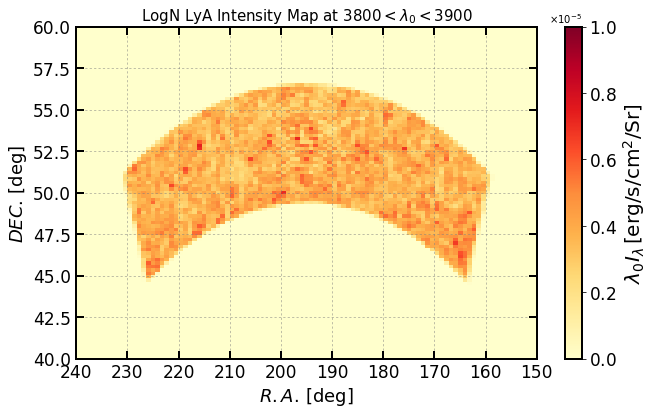

In [11]:
fig_width_pt = 760                    # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(121)
## Log or Linear
#ax.set_xscale('log')
#ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(240,150)
#ax.xaxis.set_major_locator(MultipleLocator(0.5))
#ax.xaxis.set_minor_locator(MultipleLocator(0.1))
#ax.set_ylim(-0.5,2.)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.05))
#ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.tick_params(which='minor', direction='in', length=4, width=1.5)
ax.tick_params(which='major', direction='in', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
ax.grid(b=True,which='major',color='gray',ls='dotted',lw=0.5)
## Axis label
ax.set_xlabel(r'$R.A.\,[{\rm deg}]$', fontsize=18)
ax.set_ylabel(r'$DEC.\,[{\rm deg}]$', fontsize=18)
ax.set_title(r'LogN LyA Intensity Map at $3800<\lambda_{0}<3900.$', fontsize=15)

#ax.hlines([-0.1,0.3], 22.8, 24.2, lw=2)
#ax.vlines([22.8,24.2], -0.1, 0.3, lw=2)

im = ax.imshow(hist_w .transpose(), extent=[ra_edges[0],ra_edges[-1],dec_edges[0],dec_edges[-1]], 
               vmin = 0., vmax = 1.E-5, 
               interpolation='nearest', origin='lower', cmap='YlOrRd')
#sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=2.8e-5))
#sm._A = []
sfmt = ScalarFormatter(useMathText=True)
cbar = plt.colorbar(im, format=sfmt)
cbar.ax.tick_params(labelsize=17)
cbar.set_label(r'$\lambda_{0}I_{\lambda}\,[{\rm erg/s/cm^{2}/Sr}]$', fontsize=20) 
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
#plt.colorbar(im, fraction=0.046, pad=0.04)
ax.axis('tight')
plt.savefig(HOMEDIR+'Desktop/hetdex_LogN_LyAIM_z2.pdf')
plt.show()

check the box size

In [14]:
print((cp.kpc_comoving_per_arcmin(z=1.88)*42*u.deg).to(imap.Mpcph))
print((cp.kpc_comoving_per_arcmin(z=2.54)*42*u.deg).to(imap.Mpcph))

print((cp.kpc_comoving_per_arcmin(z=1.88)*7*u.deg).to(imap.Mpcph))
print((cp.kpc_comoving_per_arcmin(z=2.54)*7*u.deg).to(imap.Mpcph))

print((cp.comoving_distance(z=2.54)-cp.comoving_distance(z=1.88)).to(imap.Mpcph))

2629.020393306096 Mpcph
3096.383027150067 Mpcph
438.170065551016 Mpcph
516.0638378583445 Mpcph
637.5692005089901 Mpcph


In [48]:
c1 = SkyCoord(164.461116*u.deg, 45.240168*u.deg)
c2 = SkyCoord(225.538884*u.deg, 45.240168*u.deg)
c1.separation(c2)

<Angle 41.92882163308189 deg>

# Angular mask in HETDEX

Configulation of IFUs in each shot

In [2]:
L_IFU = 0.0136*u.deg

dtype_IFUs = np.dtype([('x_from_fpcen', float), ('y_from_fpcen', float)])
arr_tmp = np.genfromtxt(HOMEDIR+'Dropbox/Work/Project/LAE/data/HETDEX/angular_mask/Ifus_78.dat', usecols=(0,1))
num_IFUs = arr_tmp.shape[0]

config_IFUs = np.zeros(shape=num_IFUs, dtype=dtype_IFUs)
arr_IFUs_x_from_fpcen = u.Quantity(arr_tmp[:,0],u.arcsec)
arr_IFUs_y_from_fpcen = u.Quantity(arr_tmp[:,1],u.arcsec)

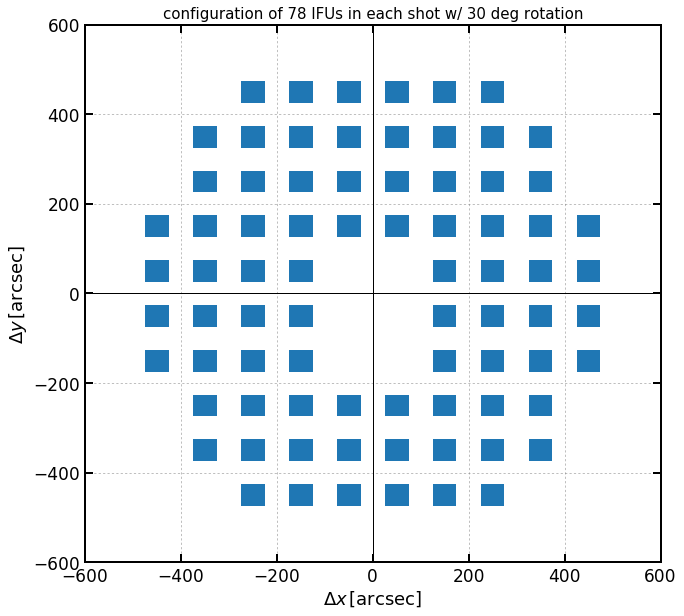

In [42]:
fig_width_pt = 760                    # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
#golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(111)
## Log or Linear
#ax.set_xscale('log')
#ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(-600.,600.)
#ax.xaxis.set_major_locator(MultipleLocator(0.5))
#ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_ylim(-600.,600.)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.05))
#ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.tick_params(which='minor', direction='in', length=4, width=1.5)
ax.tick_params(which='major', direction='in', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
ax.grid(b=True,which='major',color='gray',ls='dotted',lw=0.5)
## Axis label
ax.set_xlabel(r'$\Delta x\,[{\rm arcsec}]$', fontsize=18)
ax.set_ylabel(r'$\Delta y\,[{\rm arcsec}]$', fontsize=18)
ax.set_title(r'configuration of 78 IFUs in each shot w/ 30 deg rotation', fontsize=15)

ax.hlines(0., -600., 600., lw=1)
ax.vlines(0., -600., 600., lw=1)

rot_angle = 0*u.degree
rot_2Dmat = np.array([[np.cos(rot_angle), -np.sin(rot_angle)],
                      [np.sin(rot_angle),  np.cos(rot_angle)]])
for i in range(num_IFUs):
    corner_ll = [arr_IFUs_x_from_fpcen[i].value-L_IFU.to(u.arcsec).value/2., 
                 arr_IFUs_y_from_fpcen[i].value-L_IFU.to(u.arcsec).value/2.]
    
    corner_ll = np.matmul(rot_2Dmat, corner_ll)
    
    ax.add_patch(patches.Rectangle(corner_ll,   # (x,y)
                                   L_IFU.to(u.arcsec).value, # width
                                   L_IFU.to(u.arcsec).value, # height
                                   angle=rot_angle.value, 
                                   fill=True))

#plt.savefig(HOMEDIR+'Desktop/hetdex_IFUs_conf.pdf')
plt.show()

In [34]:
(500*u.arcsec).to(u.deg)

<Quantity 0.1388888888888889 deg>

In [ ]:
>>> center = SkyCoord(10*u.deg, 45*u.deg)
>>> aframe = center.skyoffset_frame()
>>> target.transform_to(aframe)  
<SkyOffsetICRS Coordinate (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    ( 10.,  45.)>): (lon, lat) in deg
    ( 0.69474685,  1.00428706)>

In [60]:
org    = SkyCoord(0*u.deg, 0*u.deg)
center = SkyCoord(100*u.deg, 60*u.deg)
oframe = org.skyoffset_frame()
aframe = center.skyoffset_frame()

In [76]:
tmp.ra.value

array([ 0.,  0.,  0.,  0.])

In [33]:
##### read tiling file
FoV = np.pi*0.18333**2*u.degree**2

#dtype_tiles = np.dtype([('ra', u.Quantity), ('dec', u.Quantity), ('pangle', u.Quantity)])
arr_tmp = np.genfromtxt(HOMEDIR+'Dropbox/Work/Project/LAE/data/HETDEX/angular_mask/shot_unshuffled_spring.dat', 
                        usecols=(0,1,6))
num_tiles = arr_tmp.shape[0]

arr_tiles_ra = u.Quantity(arr_tmp[:,0],u.degree)
arr_tiles_dec = u.Quantity(arr_tmp[:,1],u.degree)
arr_tiles_pangle = u.Quantity(arr_tmp[:,2],u.degree)

arr_tmp = np.genfromtxt(HOMEDIR+'Dropbox/Work/Project/LAE/data/HETDEX/angular_mask/shot_unshuffled_fall.dat', 
                        usecols=(0,1,6))
num_tilef = arr_tmp.shape[0]

arr_tilef_ra = u.Quantity(arr_tmp[:,0],u.degree)
arr_tilef_dec = u.Quantity(arr_tmp[:,1],u.degree)
arr_tilef_pangle = u.Quantity(arr_tmp[:,2],u.degree)

In [5]:
print(arr_tiles_pangle[:].min(), arr_tiles_pangle[:].max())
print(arr_tilef_pangle[:].min(), arr_tilef_pangle[:].max())

56.6172 deg 80.1277 deg
-0.0 deg -0.0 deg


In [22]:
select_ra = np.logical_and(arr_tiles_ra>=194*u.deg, arr_tiles_ra<=196*u.deg)
select_dec = np.logical_and(arr_tiles_dec>=52.*u.deg, arr_tiles_dec<=54*u.deg)

select_radec = np.logical_and(select_ra, select_dec)

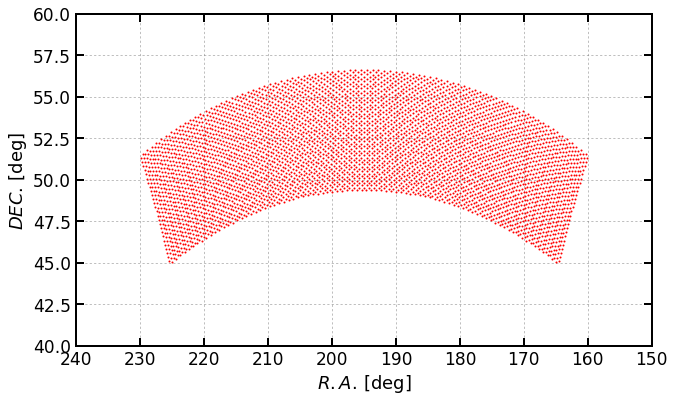

In [28]:
fig_width_pt = 760                    # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(111)
## Log or Linear
#ax.set_xscale('log')
#ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(240,150)
#ax.xaxis.set_major_locator(MultipleLocator(0.5))
#ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_ylim(40,60)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.05))
#ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.tick_params(which='minor', direction='in', length=4, width=1.5)
ax.tick_params(which='major', direction='in', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
ax.grid(b=True,which='major',color='gray',ls='dotted',lw=0.5)
## Axis label
ax.set_xlabel(r'$R.A.\,[{\rm deg}]$', fontsize=18)
ax.set_ylabel(r'$DEC.\,[{\rm deg}]$', fontsize=18)
#ax.set_title(r'configuration of 78 IFUs in each shot', fontsize=17)

#ax.hlines(0., -600., 600., lw=1)
#ax.vlines(0., -600., 600., lw=1)

ax.plot(arr_tiles_ra[:], arr_tiles_dec[:], 'ro', ms=1)
#ax.plot(arr_tilef_ra[:], arr_tilef_dec[:], 'bo', ms=1)

#for itile in range(30):
##for itile in range(10):
#    for i in range(num_IFUs):
#        center = [arr_IFUs_x_from_fpcen[i].to(u.degree).value-L_IFU.value/2., 
#                  arr_IFUs_y_from_fpcen[i].to(u.degree).value-L_IFU.value/2.]
#
#       rot_angle = arr_tiles_pangle[i]
#        rot_2Dmat = np.array([[np.cos(rot_angle),   np.sin(-rot_angle)],
#                              [np.sin(rot_angle),  np.cos(rot_angle)]])
#        center = np.matmul(rot_2Dmat, center)
#        
#        center[0] += arr_tiles_ra[itile].value
#        center[1] += arr_tiles_dec[itile].value
#        #print(center)
#        ax.add_patch(patches.Rectangle(center,   # (x,y)
#                                       L_IFU.value, # width
#                                       L_IFU.value, # height
#                                       angle=rot_angle.value, 
#                                       fill=True))

#print(center[0].min(), center[0].max())
#print(center[1].min(), center[1].max())
#plt.savefig(HOMEDIR+'Desktop/hetdex_IFUs_conf.pdf')
plt.show()

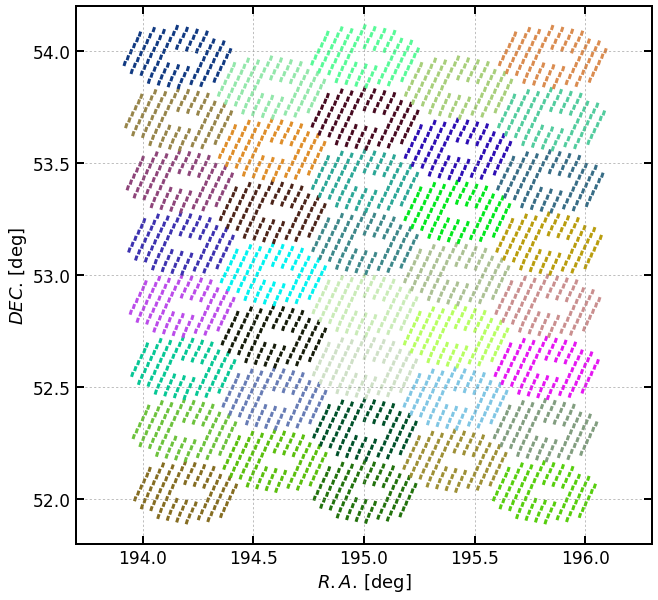

In [47]:
fig_width_pt = 760                    # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
#golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(111)
## Log or Linear
#ax.set_xscale('log')
#ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(193.7,196.3)
#ax.xaxis.set_major_locator(MultipleLocator(0.5))
#ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_ylim(51.8,54.2)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.05))
#ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.tick_params(which='minor', direction='in', length=4, width=1.5)
ax.tick_params(which='major', direction='in', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
ax.grid(b=True,which='major',color='gray',ls='dotted',lw=0.5)
## Axis label
ax.set_xlabel(r'$R.A.\,[{\rm deg}]$', fontsize=18)
ax.set_ylabel(r'$DEC.\,[{\rm deg}]$', fontsize=18)
#ax.set_title(r'configuration of 78 IFUs in each shot', fontsize=17)

#ax.hlines(0., -600., 600., lw=1)
#ax.vlines(0., -600., 600., lw=1)

#ax.plot(arr_tiles_ra[:], arr_tiles_dec[:], 'ro', ms=1)
#ax.plot(arr_tilef_ra[:], arr_tilef_dec[:], 'bo', ms=1)

#for itile in range(30):
for itile in np.where(select_radec==True)[0]:
    color = np.random.rand(3,1)
    for i in range(num_IFUs):
        corner_ll = [arr_IFUs_x_from_fpcen[i].to(u.degree).value-L_IFU.value/2., 
                     arr_IFUs_y_from_fpcen[i].to(u.degree).value-L_IFU.value/2.]

        rot_angle = arr_tiles_pangle[i]
        rot_2Dmat = np.array([[np.cos(rot_angle),  -np.sin(rot_angle)],
                              [np.sin(rot_angle),  np.cos(rot_angle)]])
        corner_ll = np.matmul(rot_2Dmat, corner_ll)
        
        corner_ll[0] = arr_tiles_ra[itile].value + corner_ll[0]/np.cos(arr_tiles_dec[itile])
        corner_ll[1] += arr_tiles_dec[itile].value 
        #print(center)
        ax.add_patch(patches.Rectangle(corner_ll,   # (x,y)
                                       L_IFU.value/np.cos(arr_tiles_dec[itile]), # width
                                       L_IFU.value, # height
                                       angle=rot_angle.value, 
                                       fc=color,
                                       fill=True))

#print(center[0].min(), center[0].max())
#print(center[1].min(), center[1].max())
#plt.savefig(HOMEDIR+'Desktop/hetdex_tile_spring.png')
plt.show()

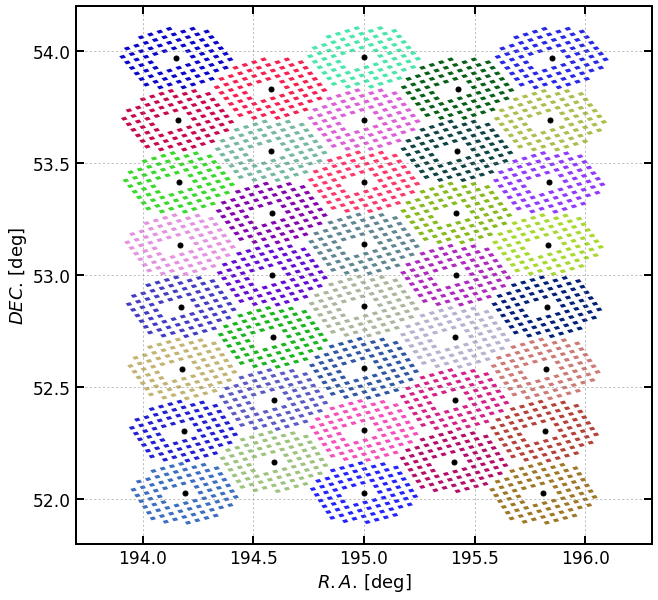

In [78]:
fig_width_pt = 760                    # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
#golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(111)
## Log or Linear
#ax.set_xscale('log')
#ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(193.7,196.3)
#ax.xaxis.set_major_locator(MultipleLocator(0.5))
#ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_ylim(51.8,54.2)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.05))
#ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.tick_params(which='minor', direction='in', length=4, width=1.5)
ax.tick_params(which='major', direction='in', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
ax.grid(b=True,which='major',color='gray',ls='dotted',lw=0.5)
## Axis label
ax.set_xlabel(r'$R.A.\,[{\rm deg}]$', fontsize=18)
ax.set_ylabel(r'$DEC.\,[{\rm deg}]$', fontsize=18)
#ax.set_title(r'configuration of 78 IFUs in each shot', fontsize=17)

ax.plot(arr_tiles_ra[select_radec], arr_tiles_dec[select_radec], 'ko', ms=5)

arr_xsign = np.array([-1,1,1,-1])
arr_ysign = np.array([-1,-1,1,1])

for itile in np.where(select_radec==True)[0]:
    color = np.random.rand(3,1)
    center = SkyCoord(arr_tiles_ra[itile], arr_tiles_dec[itile])
    aframe = center.skyoffset_frame(rotation=arr_tiles_pangle[itile])
    for i in range(num_IFUs):
        corners = np.zeros(shape=(4, 2))
        
        tmp = SkyCoord(arr_IFUs_x_from_fpcen[i] + arr_xsign[:]*L_IFU/2.,
                       arr_IFUs_y_from_fpcen[i] + arr_ysign[:]*L_IFU/2.,
                       frame=aframe)
        corners[:,0] = tmp.transform_to('icrs').ra.value
        corners[:,1] = tmp.transform_to('icrs').dec.value
        
        ax.add_patch(patches.Polygon(corners,fc=color,fill=True))

#plt.savefig(HOMEDIR+'Desktop/hetdex_tile_spring.png')
plt.show()

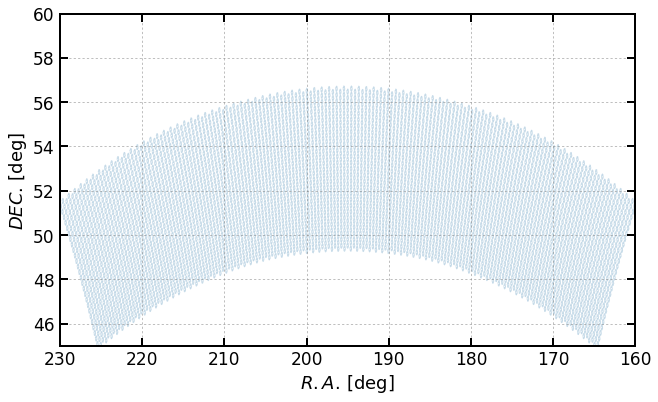

In [30]:
fig_width_pt = 760                    # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
#golden_mean = 1.
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

fig = plt.figure(1)
plt.clf()
## Range
plt.subplots_adjust(left=0.075,bottom=0.13,top=0.98,right=0.98)
ax = plt.axes([0.18,0.2,0.76,0.71])
#ax = fig.add_subplot(111)
## Log or Linear
#ax.set_xscale('log')
#ax.xaxis.set_major_formatter(formatter)   
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(formatter)   
## Axis 
ax.set_xlim(230,160)
#ax.xaxis.set_major_locator(MultipleLocator(0.5))
#ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_ylim(45.,60.)
#ax.yaxis.set_ticks([200.,400.,1000.,2000.])
#ax.yaxis.set_major_locator(MultipleLocator(0.05))
#ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.tick_params(which='minor', direction='in', length=4, width=1.5)
ax.tick_params(which='major', direction='in', length=8, width=2, pad=5)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.xaxis.get_minor_ticks():
    tick.tick2On = True
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(17)
    tick.tick2On = True
for tick in ax.yaxis.get_minor_ticks():
    tick.tick2On = True
ax.grid(b=True,which='major',color='gray',ls='dotted',lw=0.5)
## Axis label
ax.set_xlabel(r'$R.A.\,[{\rm deg}]$', fontsize=18)
ax.set_ylabel(r'$DEC.\,[{\rm deg}]$', fontsize=18)
#ax.set_title(r'configuration of 78 IFUs in each shot', fontsize=17)

#ax.hlines(0., -600., 600., lw=1)
#ax.vlines(0., -600., 600., lw=1)

#ax.plot(arr_tiles_ra[:], arr_tiles_dec[:], 'ro', ms=1)
#ax.plot(arr_tilef_ra[:], arr_tilef_dec[:], 'bo', ms=1)

#for itile in range(30):
for itile in range(num_tiles):
    for i in range(num_IFUs):
        corner_ll = [arr_IFUs_x_from_fpcen[i].to(u.degree).value-L_IFU.value/2., 
                     arr_IFUs_y_from_fpcen[i].to(u.degree).value-L_IFU.value/2.]

        rot_angle = arr_tiles_pangle[i]
        rot_2Dmat = np.array([[np.cos(rot_angle),  -np.sin(rot_angle)],
                              [np.sin(rot_angle),  np.cos(rot_angle)]])
        corner_ll = np.matmul(rot_2Dmat, corner_ll)
        
        corner_ll[0] += arr_tiles_ra[itile].value
        corner_ll[1] += arr_tiles_dec[itile].value
        #print(center)
        ax.add_patch(patches.Rectangle(corner_ll,   # (x,y)
                                       L_IFU.value, # width
                                       L_IFU.value, # height
                                       angle=rot_angle.value, 
                                       fill=True))

#print(center[0].min(), center[0].max())
#print(center[1].min(), center[1].max())
plt.savefig(HOMEDIR+'Desktop/hetdex_tile_spring.png')
plt.show()

In [20]:
def judge_point_in_rectangle(point, rec): 
    r"""
    """
    signs = np.zeros(shape=(point.shape[0],4))
    judge = np.zeros(shape=(point.shape[0],), dtype=np.bool)
    
    signs[:,0] = np.sign(np.cross(rec[1,:]-rec[0,:], point[:,0:2]-rec[0,:]))
    signs[:,1] = np.sign(np.cross(rec[2,:]-rec[1,:], point[:,0:2]-rec[1,:]))
    signs[:,2] = np.sign(np.cross(rec[3,:]-rec[2,:], point[:,0:2]-rec[2,:]))
    signs[:,3] = np.sign(np.cross(rec[0,:]-rec[3,:], point[:,0:2]-rec[3,:]))

    inside = np.where(np.logical_or(np.sum(signs, axis=1)==4., np.sum(signs, axis=1)==-4.))[0]
    judge[inside] = True
    
    return judge

# Test: mask logN particle data (Ongoing)

In [17]:
data = open(DIRDATA+'LAI_poisson_lognormal_is100_rlz0_Pnmax512_b1.5.bin','rb')
        
Lx = unpack('<d', data.read(8))[0]
Ly = unpack('<d', data.read(8))[0]
Lz = unpack('<d', data.read(8))[0]
Ngal = unpack('<i', data.read(4))[0]

print(Lx,Ly,Lz,Ngal)

# read pos and vel of each galaxy
arr_LAIs = np.zeros(shape=(Ngal, 7))
for i in range(Ngal):
    arr_LAIs[i,0] = unpack('<f', data.read(4))[0]
    arr_LAIs[i,1] = unpack('<f', data.read(4))[0]
    arr_LAIs[i,2] = unpack('<f', data.read(4))[0]
    arr_LAIs[i,3] = unpack('<f', data.read(4))[0]
    arr_LAIs[i,4] = unpack('<f', data.read(4))[0]
    arr_LAIs[i,5] = unpack('<f', data.read(4))[0]
    arr_LAIs[i,6] = 10.**unpack('<f', data.read(4))[0]

2880.0 483.75 635.625 34434951


convert particle coordinates (X,Y,Z) to (ra, dec, distance)

In [18]:
skyc_LAIs = imap.convert_arrpos_to_skycoord(arr_LAIs[:,0:3])

In [29]:
rec = np.array([[190,52],[200,52],[200,54],[190,54]])
points = np.transpose([skyc_LAIs.ra[:],skyc_LAIs.dec[:]])
print(np.where(judge_point_in_rectangle(points,rec)==True)[0].shape[0])

1372104


In [31]:
4400*78

343200

In [42]:
arr_recs = np.zeros(shape=(num_tiles, num_IFUs, 4, 2))
for ishot in range(num_tiles):
    for j in range(num_IFUs):
        corner_ll = np.array([arr_IFUs_x_from_fpcen[j].to(u.degree).value-L_IFU.value/2., 
                     arr_IFUs_y_from_fpcen[j].to(u.degree).value-L_IFU.value/2.])

        rot_angle = arr_tiles_pangle[ishot]
        rot_2Dmat = np.array([[np.cos(rot_angle), -np.sin(rot_angle)],
                              [np.sin(rot_angle),  np.cos(rot_angle)]])
        corner_ll = np.matmul(rot_2Dmat, corner_ll)
        
        #Lower-Left
        arr_recs[ishot,j,0,0] = corner_ll[0] + arr_tiles_ra[ishot].value
        arr_recs[ishot,j,0,1] = corner_ll[1] + arr_tiles_dec[ishot].value
        
        #Lower-Right
        arr_recs[ishot,j,1,:] = arr_recs[ishot,j,0,:] + np.matmul(rot_2Dmat, np.array([L_IFU.value, 0]))
        
        #Upper-Right
        arr_recs[ishot,j,2,:] = arr_recs[ishot,j,0,:] + np.matmul(rot_2Dmat, np.array([L_IFU.value, L_IFU.value]))
    
        #Upper-Left
        arr_recs[ishot,j,3,:] = arr_recs[ishot,j,0,:] + np.matmul(rot_2Dmat, np.array([0, L_IFU.value]))